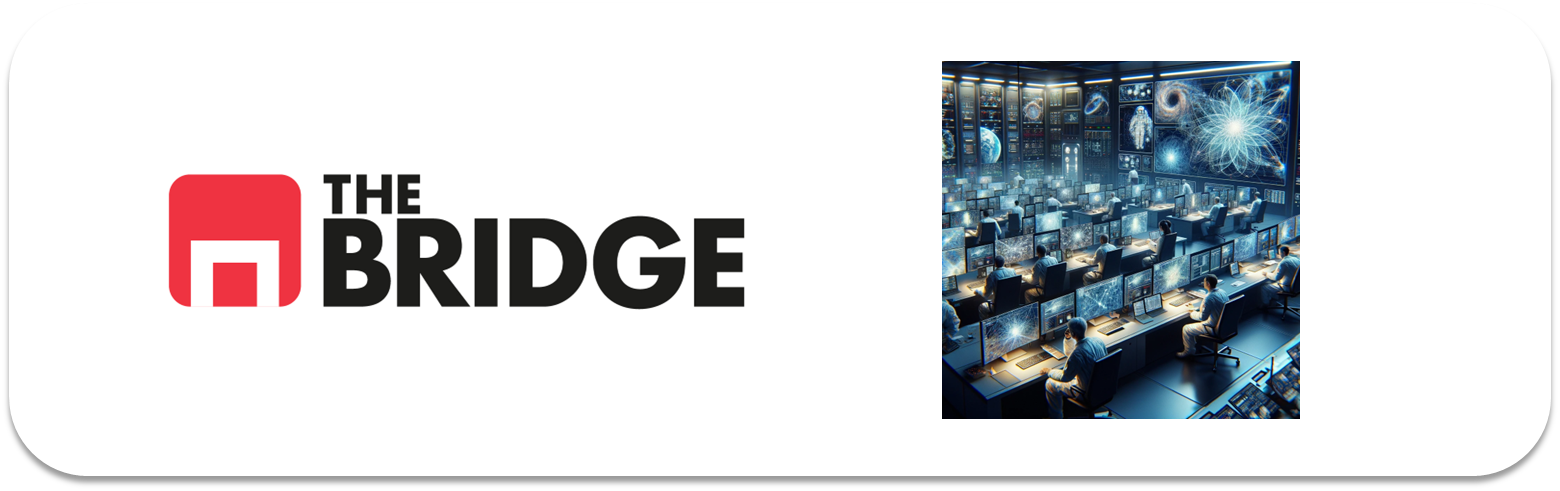

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.option_context('mode.use_inf_as_na', True)

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPool2D,Conv2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import random

from PIL import Image
import os

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



## Carga de datos

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

In [2]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            label = 0 if "cat" in filename else 1  # 0 para gatos, 1 para perros
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize((32, 32), Image.Resampling.LANCZOS) # Puse NEAREST pero me daba prácticamente igual
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos de entrenamiento de las 4 carpetas
train_dirs = ['./data/github_train_0', './data/github_train_1', './data/github_train_2', './data/github_train_3']
X_train = []
y_train = []

for train_dir in train_dirs:
    images, labels = load_images_from_directory(train_dir)
    X_train.extend(images)
    y_train.extend(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)
print('Dimensiones X_train',X_train.ndim)
print('Size X_train', X_train.size)
print(X_train.shape)
print(X_train[0].shape)
print(X_train[0][0])
print()
print('Dimensiones y_train',y_train.ndim)
print('Size y_train', y_train.size)
print(y_train.shape)
print(y_train[0])
print('*'* 25)

# Cargar datos de prueba
test_dir = './data/github_test'
X_test, y_test = load_images_from_directory(test_dir)
print('Dimensiones X_test',X_test.ndim)
print('Size X_test', X_test.size)
print(X_test.shape)
print(X_test[0].shape)
print(X_test[0][0])
print()
print('Dimensiones y_test',y_test.ndim)
print('Size y_test', y_test.size)
print(y_test.shape)
print(y_test[0])

# Normalizar las imágenes
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)



Dimensiones X_train 4
Size X_train 12288000
(4000, 32, 32, 3)
(32, 32, 3)
[[126 100  65]
 [115  89  51]
 [149 124  82]
 [185 161 119]
 [234 210 170]
 [215 205 175]
 [249 250 232]
 [217 206 183]
 [203 187 158]
 [171 147 114]
 [182 155 107]
 [132 108  57]
 [138 118  72]
 [160 142  99]
 [ 77  57  25]
 [ 78  53  30]
 [ 91  64  36]
 [ 83  57  35]
 [ 57  45  23]
 [ 39  33  19]
 [ 63  54  37]
 [ 85  68  40]
 [145 125  93]
 [139 124  94]
 [119 102  78]
 [138 122  89]
 [129 113  85]
 [101  87  61]
 [ 71  72  47]
 [ 90  70  49]
 [128  68  44]
 [111  59  37]]

Dimensiones y_train 1
Size y_train 4000
(4000,)
0
*************************
Dimensiones X_test 4
Size X_test 3072000
(1000, 32, 32, 3)
(32, 32, 3)
[[196 193 177]
 [198 193 175]
 [197 191 174]
 [196 190 178]
 [195 191 176]
 [196 190 174]
 [195 188 173]
 [194 189 173]
 [196 190 173]
 [192 189 170]
 [192 189 172]
 [192 188 171]
 [190 186 169]
 [189 186 170]
 [189 186 169]
 [188 185 168]
 [187 184 166]
 [186 183 168]
 [185 181 170]
 [185 182 16

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

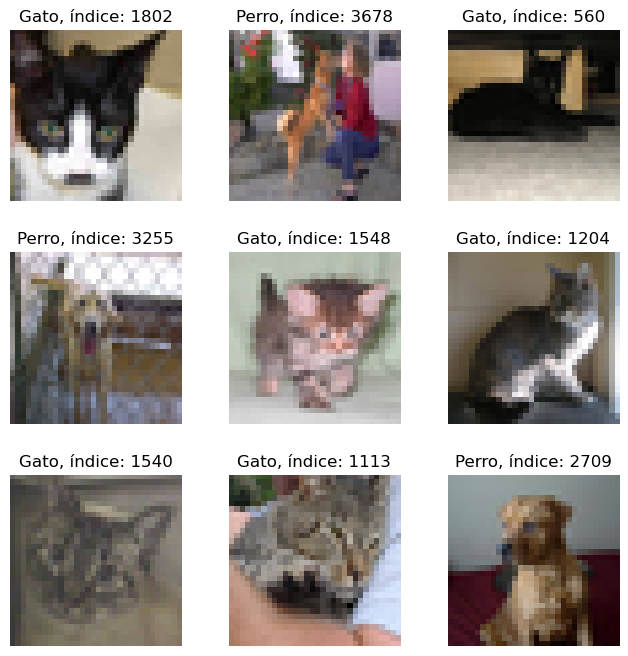

In [3]:
# Seleccionar aleatoriamente 9 imágenes para visualización
sample_indices = np.random.randint(0, len(X_train), size=9)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i,index in enumerate(sample_indices):
    axes[i].imshow(X_train[index])
    label = 'Gato' if y_train[index] == 0 else 'Perro'
    axes[i].set_title(f"{label}, índice: {index}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.show()

Pues se ve fatal con respecto a la resolución con la que vienen en los archivos.   
No se distingue si es perro o gato.  
De aquí no sé qué información se va a obtener...

In [4]:
model = Sequential()

# Primera capa convolucional
# Como no tengo criterio he copiado los parámetros del wkb de la unidad 1
model.add(Conv2D(filters = 8, kernel_size = (3,3), padding = 'same',
          activation = 'relu', input_shape= (32,32,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(rate=0.25))

# Segunda capa convolucional
model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'same',
          activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(rate=0.25))

# Aplanamiento y capas densas
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
#model.add(Dense(128, activation = 'relu')) # Me da casi el mismo resultado añadiendo más capas densas que sin añadir.
#model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.50)) # Parece que con 0.50 da algo mejor de resultado que con inferiores

# Capa de salida
model.add(Dense(2, activation = 'sigmoid'))

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()      

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,354 (1.02 MB)

 Trainable params: 266,354 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

In [5]:
# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=50, batch_size=64, callbacks=[early_stopping])
# Daba constnatemente error en los datos de y_train e y_test. He tenido que convertirlos en categóricos (arriba en la función inicial)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5159 - loss: 0.7173 - val_accuracy: 0.5290 - val_loss: 0.6887
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5704 - loss: 0.6826 - val_accuracy: 0.5960 - val_loss: 0.6619
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5992 - loss: 0.6554 - val_accuracy: 0.5890 - val_loss: 0.6528
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6396 - loss: 0.6334 - val_accuracy: 0.6760 - val_loss: 0.6192
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6657 - loss: 0.6103 - val_accuracy: 0.6290 - val_loss: 0.6237
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6800 - loss: 0.5930 - val_accuracy: 0.6440 - val_loss: 0.6233
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6909 - loss: 0.5842 - val_accuracy: 0.6870 - val_loss: 0.5854
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6970 - loss: 0.5788 - val_accuracy: 0.7010 - v

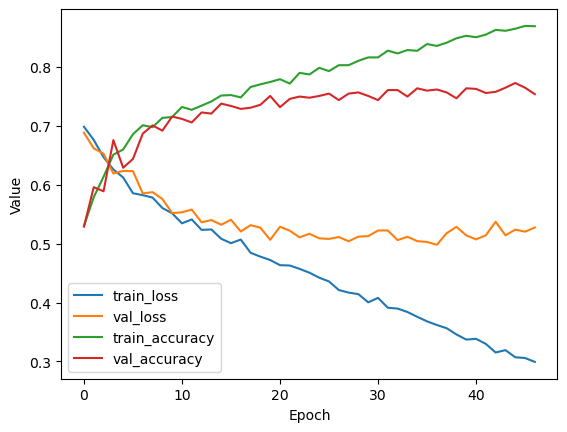

In [6]:
# Visualización del historial de entrenamiento
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

In [7]:
# Evaluación del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Reporte de clasificación
print(classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog']))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

         Cat       0.77      0.75      0.76       500
         Dog       0.76      0.77      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



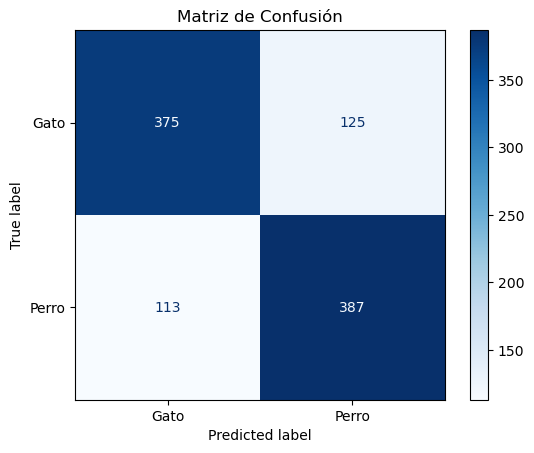

In [8]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Gato', 'Perro'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.

In [9]:
# Obtener predicciones y probabilidades
y_pred_probs = np.max(y_pred, axis=1)
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Crear una lista de imágenes y un DataFrame para análisis
images = [X_test[i] for i in incorrect_indices]
data = {
    'true_label': y_true[incorrect_indices],
    'pred_label': y_pred_classes[incorrect_indices],
    'pred_prob': y_pred_probs[incorrect_indices]
}

df = pd.DataFrame(data)
df

,true_label,pred_label,pred_prob
0,0,1,0.523549
1,0,1,0.778214
2,0,1,0.706557
3,0,1,0.955131
4,0,1,0.755609
...,...,...,...
233,1,0,0.862315
234,1,0,0.545874
235,1,0,0.529239
236,1,0,0.798854


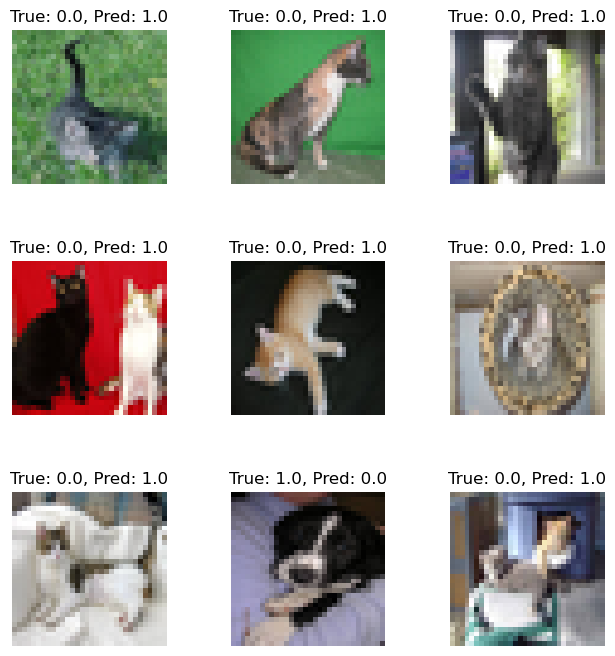

In [10]:
# Seleccionar el 10% de imágenes mal clasificadas con mayor probabilidad
num_to_select = len(df) // 10
difficult_images = df.nlargest(num_to_select, 'pred_prob')

# Mostrar algunas de las imágenes difíciles
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i in np.arange(0, 9):
    if i < len(difficult_images):
        img = images[difficult_images.index[i]]
        axes[i].imshow(img)
        axes[i].set_title(f"True: {difficult_images.iloc[i]['true_label']}, Pred: {difficult_images.iloc[i]['pred_label']}")
        axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()